# How Classification Comes to Be...

- First, let's import the "credit" dataset by installing the ISLP module and learning how to load directly from our package...
  - [Link to package](https://github.com/intro-stat-learning/ISLP): Always research the packages you install!
  - [Documentation](https://intro-stat-learning.github.io/ISLP/datasets/Default.html) on how to use the ISLP package!

### Data Dictionary:

`default`: A factor with levels ‘No’ and ‘Yes’ indicating whether the customer defaulted on their debt

`student`: A factor with levels ‘No’ and ‘Yes’ indicating whether the customer is a student

`balance`: The average balance that the customer has remaining on their credit card after making their monthly payment

`income`: Income of customer

In [1]:
# run this code then restart your runtime above!
! pip install ISLP


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 350.7/350.7 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.2/522.2 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.7/727.7 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 20.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.0/91.0 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 33.7 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=1c57794059ce1d6be41f699dca0b0bbf02fe4ed8f9b3392fa3e07da5b7411f8e
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstall

#### ALWAYS remember to resart your runtime after you install a package!

In [1]:
from ISLP import load_data
default_data = load_data('Default')
default_data.columns

Index(['default', 'student', 'balance', 'income'], dtype='object')

In [2]:
default_data.head()

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879


In [3]:
default_data['student'].value_counts()

No     7056
Yes    2944
Name: student, dtype: int64

In [4]:
default_data['default'].value_counts()

No     9667
Yes     333
Name: default, dtype: int64

### First let's convert No and Yes to 0 and 1 respectively.

In [5]:
# know how to do this!!
mapping = {'No': 0,'Yes': 1}
default_data['student'] = default_data['student'].map(mapping)
default_data['default'] = default_data['default'].map(mapping)

In [6]:
default_data.head()

,default,student,balance,income
0,0,0,729.526495,44361.625074
1,0,1,817.180407,12106.134700
2,0,0,1073.549164,31767.138947
3,0,0,529.250605,35704.493935
4,0,0,785.655883,38463.495879


# Train Test Split

In [7]:
from numpy.random.mtrand import seed
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

X = default_data[["balance"]]
y = default_data[["default"]]

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=.15,
                                                    random_state=2489,
                                                    shuffle=True) # shuffle our data!!


# Predicting Our Logistic Regression

In [8]:
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

In [9]:
# Our results are normal, except we have an oddly low R-Squared
model = sm.Logit(y_train, X_train).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.080463
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                default   No. Observations:                 8500
Model:                          Logit   Df Residuals:                     8498
Method:                           MLE   Df Model:                            1
Date:                Thu, 05 Oct 2023   Pseudo R-squ.:                  0.4444
Time:                        23:48:29   Log-Likelihood:                -683.93
converged:                       True   LL-Null:                       -1231.0
Covariance Type:            nonrobust   LLR p-value:                6.317e-240
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.5324      0.388    -27.179      0.000     -11.292      -9.773
balance        0.0054      0

In [10]:
from pandas import DataFrame

DataFrame(model.params).T

,const,balance
0,-10.532374,0.005409


# Estimating Probabilities with Logits

The estimated probability of default with a balance of $1,000 is given by

$\hat{p}(X = \$1000) = \frac{e^{-10.532374+0.005409•1000}}{1 + e^{-10.532374+0.005409•1000}}$


The estimated probability of default with a balance of $2,000 is given by

$\hat{p}(X = \$2000) = \frac{e^{-10.532374+0.005409•2000}}{1 + e^{-10.532374+0.005409•2000}}$


# But Our Coefficients Don't Represent Outright Probabilities, Let's Find Them


## Calculating Probabilities from our Coefficients

In [11]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Get the fitted values (log odds)
log_odds = model.fittedvalues

# Convert log odds to probabilities
probabilities = np.exp(log_odds) / (1 + np.exp(log_odds))

The formula to convert log-odds ($e^{\beta_{0}+\beta_{1}x_1}$) to probability ($P$) is expressed in LaTeX as follows:

$P$ = $\frac{e^{\beta_{0}+\beta_{1}x_1}}{1 + e^{\beta_{0}+\beta_{1}x_1}}$


In this formula:

- e is the base of the natural logarithm,
- $e^{\beta_{0}+\beta_{1}x_1}$ is the log-odds, which is the product of the feature values and the coefficients from the logistic regression model
- P is the probability of the positive class.

**Note:** Multiply by 100 to get percentages from the Logit predictions of the statsmodels Logit model.

In [12]:
probabilities*100

4081    0.108923
1501    0.021644
3161    2.953299
397     0.145609
8551    0.911655
          ...   
3180    0.083155
7438    0.073807
913     0.015994
2730    0.203620
7992    0.004152
Length: 8500, dtype: float64

In [13]:
preds = model.predict(X_train)

In [14]:
# Notice that Logit percentages are the same as above.
preds*100

4081    0.108923
1501    0.021644
3161    2.953299
397     0.145609
8551    0.911655
          ...   
3180    0.083155
7438    0.073807
913     0.015994
2730    0.203620
7992    0.004152
Length: 8500, dtype: float64

## Add All Variables, Prediction Probablities to DF

In [15]:
X = default_data.drop("default", axis=1)
y = default_data[["default"]]

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=.15,
                                                    random_state=2489,
                                                    shuffle=True)

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

model = sm.Logit(y_train, X_train).fit()

X_train['pred_prob'] = preds*100
X_train.head()

Optimization terminated successfully.
         Current function value: 0.079173
         Iterations 10


,const,student,balance,income,pred_prob
4081,1.0,0,686.163295,33190.427129,0.108923
1501,1.0,0,387.236143,24243.944458,0.021644
3161,1.0,0,1301.650765,38918.994168,2.953299
397,1.0,1,739.901759,25023.873856,0.145609
8551,1.0,1,1080.477662,18741.316863,0.911655


# Assessing Our Model


In [16]:
X_train['true_default'] = y_train

In [17]:
true_df = X_train.reset_index(drop=True)

<Axes: xlabel='true_default', ylabel='pred_prob'>

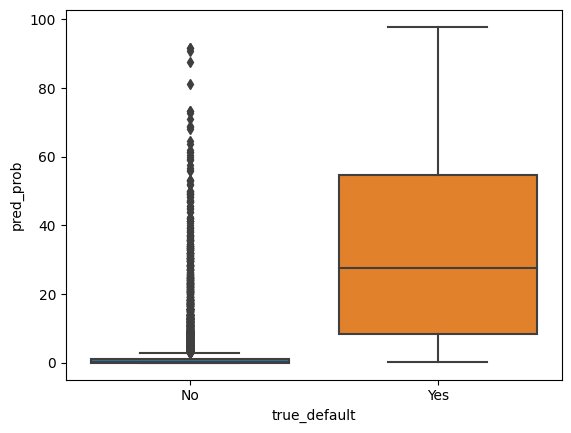

In [18]:
import seaborn as sns

mapping = {0: 'No', 1: 'Yes'}
true_df['true_default'] = true_df['true_default'].map(mapping)
sns.boxplot(data=true_df, x='true_default', y='pred_prob',)

<Axes: xlabel='pred_prob', ylabel='Count'>

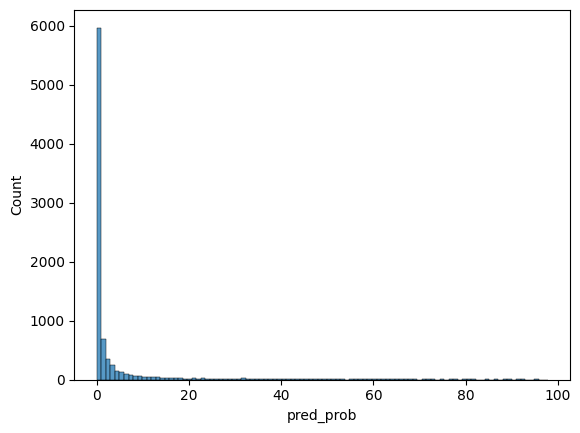

In [19]:
sns.histplot(data=true_df, x='pred_prob', bins=100)

# Generating Confusion Matrices Using Sklearn

In [20]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)

### Let's convert our predicted probabilities to classifications

threshold = 0.5 # if greater than or equal to 50% probability then 1, else 0
y_pred_classes = (y_pred >= threshold).astype(int)

conf_matrix = confusion_matrix(y_test, y_pred_classes)
print(conf_matrix)

[[1442    5]
 [  36   17]]


In the Confusion Matrix above...
- The first row represents the actual negative class (0):
  - `1442` is the number of True Negatives (TN)
  - `5` is the number of False Positives (FP)
- The second row represents the actual positive class (1):
  - `36` is the number of False Negatives (FN)
  - `17` is the number of True Positives (TP)


  But let's make this a more readable, interpretable chart...

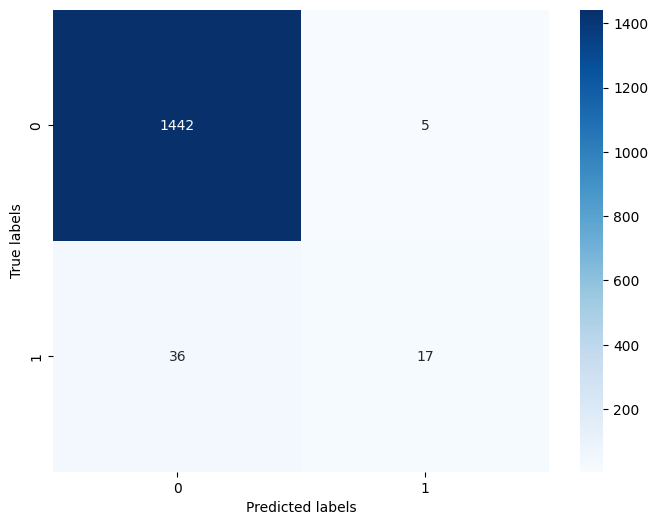

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the confusion matrix with Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues") ### heatmap
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

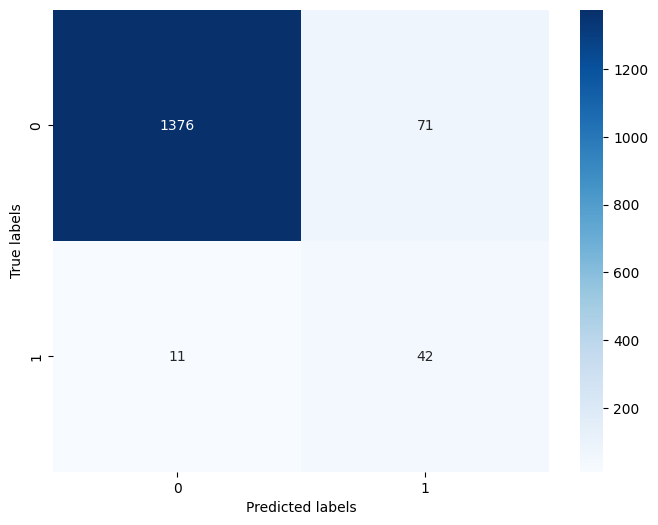

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# What if we change the threshold downward?
threshold = 0.1
y_pred_classes = (y_pred >= threshold).astype(int)

conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plotting the confusion matrix with Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

Here we identify more True Positives than before, but at the expense of also raising the False Positive and False Negative Rates.

# ROC Curves + Plots

Instead of plotting many confusion matrices, it would be nice if we could see what the trade-off is between *all* of the possibilities of our thresholds. Particularly, it would be nice to see how each threshold affected our False Positive and False Negative Rates.

Enter: the Receiver Operating Characteristic (ROC) Curve

In [26]:
from sklearn.metrics import roc_curve, roc_auc_score

# here we provide all the *probabilities* of our predictions, and their corresponding true y values
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

`fpr` and `tpr` are two arrays that represent the false positive rate and true positive rate at \( n \) different unique probability thresholds that the provided predicted probability data can be sliced into. Specifically:

- **False Positive Rate (FPR)**: This rate, represented by the `fpr` array, gives us the fraction of actual negatives that are incorrectly predicted as positive for each threshold. It's computed as:

${FPR} = \frac{\text{False Positives (FP)}}{\text{False Positives (FP) + True Negatives (TN)}}$

- **True Positive Rate (TPR)**: Also known as Sensitivity or Recall, this rate, represented by the `tpr` array, indicates the fraction of actual positives that are correctly predicted as positive for each threshold. It's defined as:

${TPR} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP) + False Negatives (FN)}}$

The `roc_curve` function from `scikit-learn` computes these rates for every unique threshold present in the predicted probabilities. By plotting `fpr` against `tpr` for these thresholds, we generate the ROC (Receiver Operating Characteristic) curve. This curve illustrates the trade-offs between sensitivity (TPR) and specificity (1-FPR) for a binary classifier, helping us understand its performance across various decision thresholds.

When interpreting the ROC curve, a point closer to the top-left corner represents a better trade-off, with higher true positive rates and lower false positive rates. The area under the ROC curve, known as AUC (Area Under the Curve), provides a single metric summarizing the overall discriminative ability of the classifier across all thresholds.

In [ ]:
print(f"These are our True Positive Rates {tpr[:5]}")
print(f"These are our False Positive Rates {fpr[:5]}")
print(f"These are our Thresholds {thresholds[:5]}")

These are our True Positive Rates [0.         0.01886792 0.20754717 0.20754717 0.22641509]
These are our False Positive Rates [0.         0.         0.         0.00069109 0.00069109]
These are our Thresholds [1.96069096 0.96069096 0.69886932 0.69151267 0.66358949]


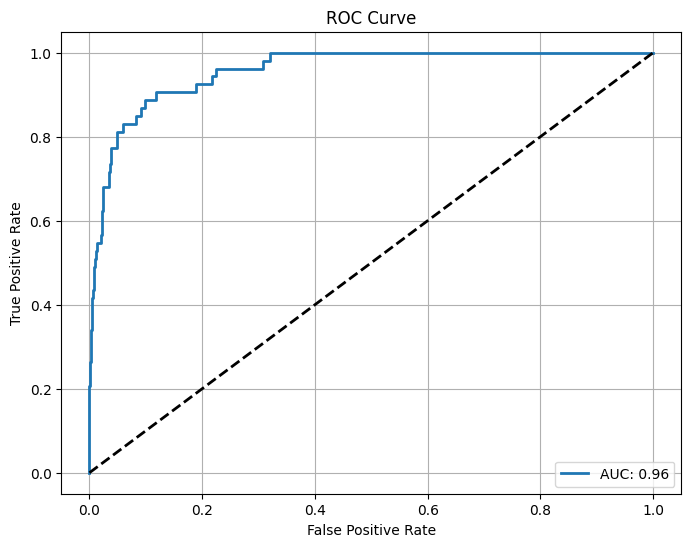

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=2, label=f'AUC: {roc_auc_score(y_test, y_pred):.2f}')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


**AUC (Area Under the Curve)**:

The AUC represents the area under the ROC (Receiver Operating Characteristic) curve. It provides a single scalar value that summarizes the overall performance of a binary classifier across all possible thresholds.

- The AUC value ranges from 0 to 1.
- An AUC of 0.5 suggests that the model's ability to distinguish between the positive and negative classes is no better than random guessing.
- An AUC of 1.0 indicates perfect classification, where the model correctly classifies all instances.
- Generally, a higher AUC indicates better classifier performance. However, in some rare cases, a model with a higher AUC might not be the best operational choice depending on the specific costs associated with false positives and false negatives.

${AUC} = \int_{0}^{1} {TPR(FPR)} \, d{FPR}$

This equation represents the integral of the TPR as a function of FPR over the interval [0,1], effectively computing the area under the ROC curve.

---

The `roc_auc_score` function in `scikit-learn` computes the AUC value for a set of true labels and predicted probabilities. It's a widely used metric to compare and evaluate the performance of different classifiers.